<a href="https://colab.research.google.com/github/JAYANTHNITW/Computer-Vision-projects/blob/main/object_detection_keras_cv_saving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection with KerasCV

**Author:** [lukewood](https://twitter.com/luke_wood_ml)<br>
**Date created:** 2023/04/08<br>
**Last modified:** 2023/08/10<br>
**Description:** Train an object detection model with KerasCV.

In [ ]:
!pip install --upgrade -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 3.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm

Using TensorFlow backend


In [ ]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)

This can be used as our inference preprocessing pipeline:

`keras_cv.visualization.plot_bounding_box_gallery()` supports a `class_mapping`
parameter to highlight what class each box was assigned to.  Let's assemble a
class mapping now.

In [ ]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

Just like any other `keras.Model` you can predict bounding boxes using the
`model.predict()` API.

Next, let's re-configure `keras_cv.layers.MultiClassNonMaxSuppression` for our
use case!
In this case, we will tune the `iou_threshold` to `0.2`, and the
`confidence_threshold` to `0.7`.

Raising the `confidence_threshold` will cause the model to only output boxes
that have a higher confidence score. `iou_threshold` controls the threshold of
intersection over union (IoU) that two boxes must have in order for one to be
pruned out.
[More information on these parameters may be found in the TensorFlow API docs](https://www.tensorflow.org/api_docs/python/tf/image/combined_non_max_suppression)

In [ ]:
BATCH_SIZE = 4

## Data loading

To get started, let's discuss data loading and bounding box formatting.
KerasCV has a predefined format for bounding boxes.
To comply with this, you
should package your bounding boxes into a dictionary matching the
specification below:

```
bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': Tensor(shape=[batch, num_boxes])
}
```

`bounding_boxes['boxes']` contains the coordinates of your bounding box in a KerasCV
supported `bounding_box_format`.
KerasCV requires a `bounding_box_format` argument in all components that process
bounding boxes.
This is done to maximize your ability to plug and play individual components
into their object detection pipelines, as well as to make code self-documenting
across object detection pipelines.

To match the KerasCV API style, it is recommended that when writing a
custom data loader, you also support a `bounding_box_format` argument.
This makes it clear to those invoking your data loader what format the bounding boxes
are in.
In this example, we format our boxes to `xywh` format.

For example:

```python
train_ds, ds_info = your_data_loader.load(
    split='train', bounding_box_format='xywh', batch_size=8
)
```

This clearly yields bounding boxes in the format `xywh`.  You can read more about
KerasCV bounding box formats [in the API docs](https://keras.io/api/keras_cv/bounding_box/formats/).

Our data comes loaded into the format
`{"images": images, "bounding_boxes": bounding_boxes}`.  This format is
supported in all KerasCV preprocessing components.

Let's load some data and verify that the data looks as we expect it to.

In [ ]:

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": tf.cast(inputs["objects"]["label"], dtype=tf.float32),
        "boxes": tf.cast(boxes, dtype=tf.float32),
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds


train_ds = load_pascal_voc(
    split="train", dataset="voc/2007", bounding_box_format="xywh"
)
eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xywh")

train_ds = train_ds.shuffle(BATCH_SIZE * 4)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteH6KSIB/voc-test.tfrecord*...:   0%|          | 0/…

Generating train examples...:   0%|          | 0/2501 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteH6KSIB/voc-train.tfrecord*...:   0%|          | 0…

Generating validation examples...:   0%|          | 0/2510 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/4.0.0.incompleteH6KSIB/voc-validation.tfrecord*...:   0%|        …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/4.0.0. Subsequent calls will reuse this data.


Next, let's batch our data.

In KerasCV object detection tasks it is recommended that
users use ragged batches of inputs.
This is due to the fact that images may be of different sizes in PascalVOC,
as well as the fact that there may be different numbers of bounding boxes per
image.

To construct a ragged dataset in a `tf.data` pipeline, you can use the
`ragged_batch()` method.

In [ ]:
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

Let's make sure our dataset is following the format KerasCV expects.
By using the `visualize_dataset()` function, you can visually verify
that your data is in the format that KerasCV expects.  If the bounding boxes
are not visible or are visible in the wrong locations that is a sign that your
data is mis-formatted.

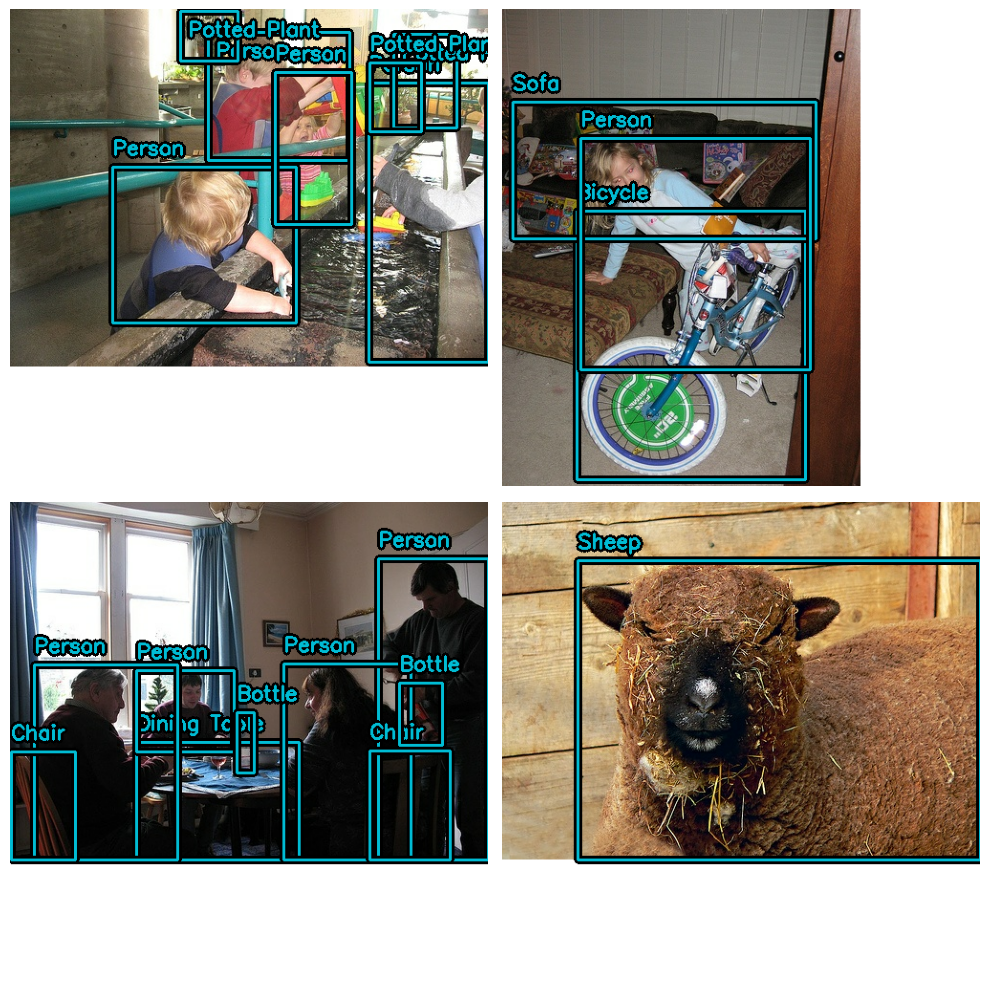

In [ ]:
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

And for the eval set:

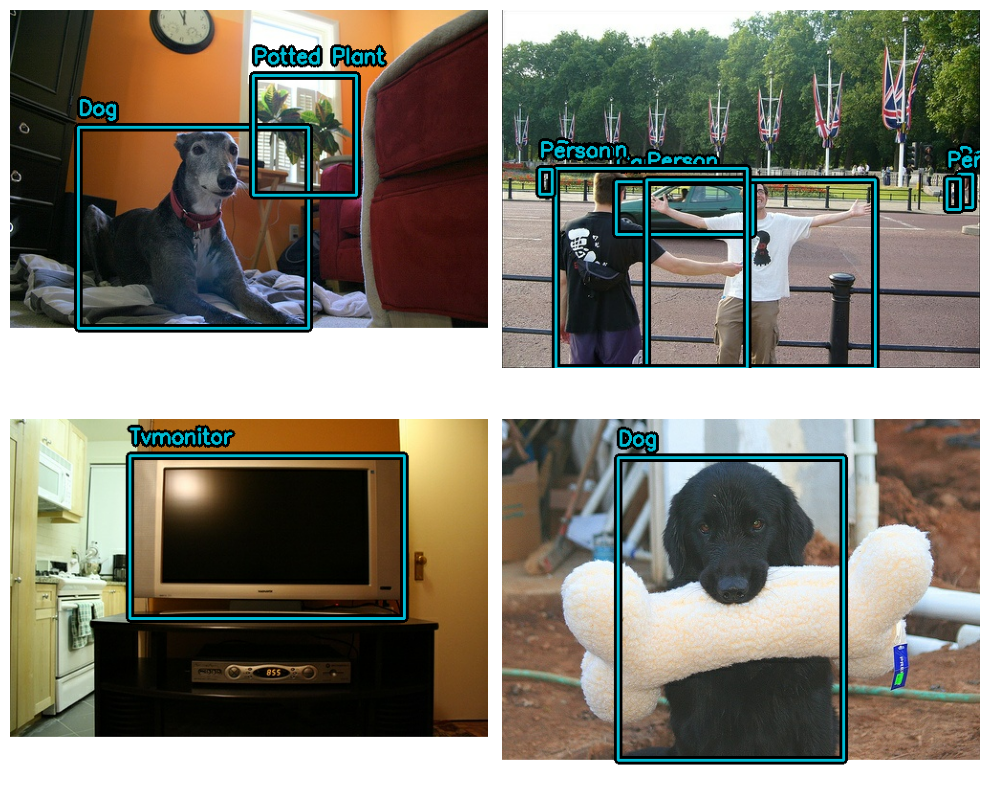

In [ ]:
visualize_dataset(
    eval_ds,
    bounding_box_format="xywh",
    value_range=(0, 255),
    rows=2,
    cols=2,
    # If you are not running your experiment on a local machine, you can also
    # make `visualize_dataset()` dump the plot to a file using `path`:
    # path="eval.png"
)

Looks like everything is structured as expected.
Now we can move on to constructing our
data augmentation pipeline.

## Data augmentation

One of the most challenging tasks when constructing object detection
pipelines is data augmentation.  Image augmentation techniques must be aware of the underlying
bounding boxes, and must update them accordingly.

Luckily, KerasCV natively supports bounding box augmentation with its extensive
library
of [data augmentation layers](https://keras.io/api/keras_cv/layers/preprocessing/).
The code below loads the Pascal VOC dataset, and performs on-the-fly,
bounding-box-friendly data augmentation inside a `tf.data` pipeline.

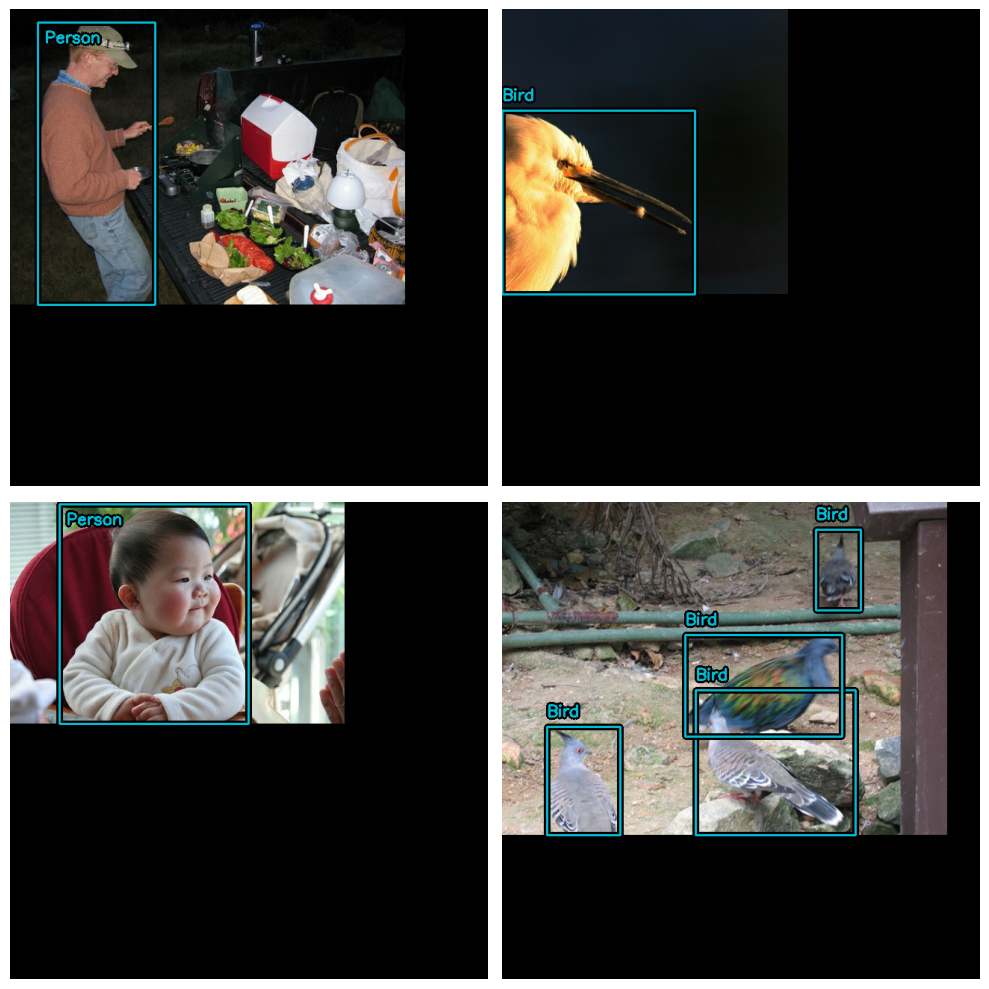

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
        ),
    ]
)

train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

Great! We now have a bounding-box-friendly data augmentation pipeline.
Let's format our evaluation dataset to match.  Instead of using
`JitteredResize`, let's use the deterministic `keras_cv.layers.Resizing()`
layer.

In [ ]:
inference_resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

Due to the fact that the resize operation differs between the train dataset,
which uses `JitteredResize()` to resize images, and the inference dataset, which
uses `layers.Resizing(pad_to_aspect_ratio=True)`, it is good practice to
visualize both datasets:

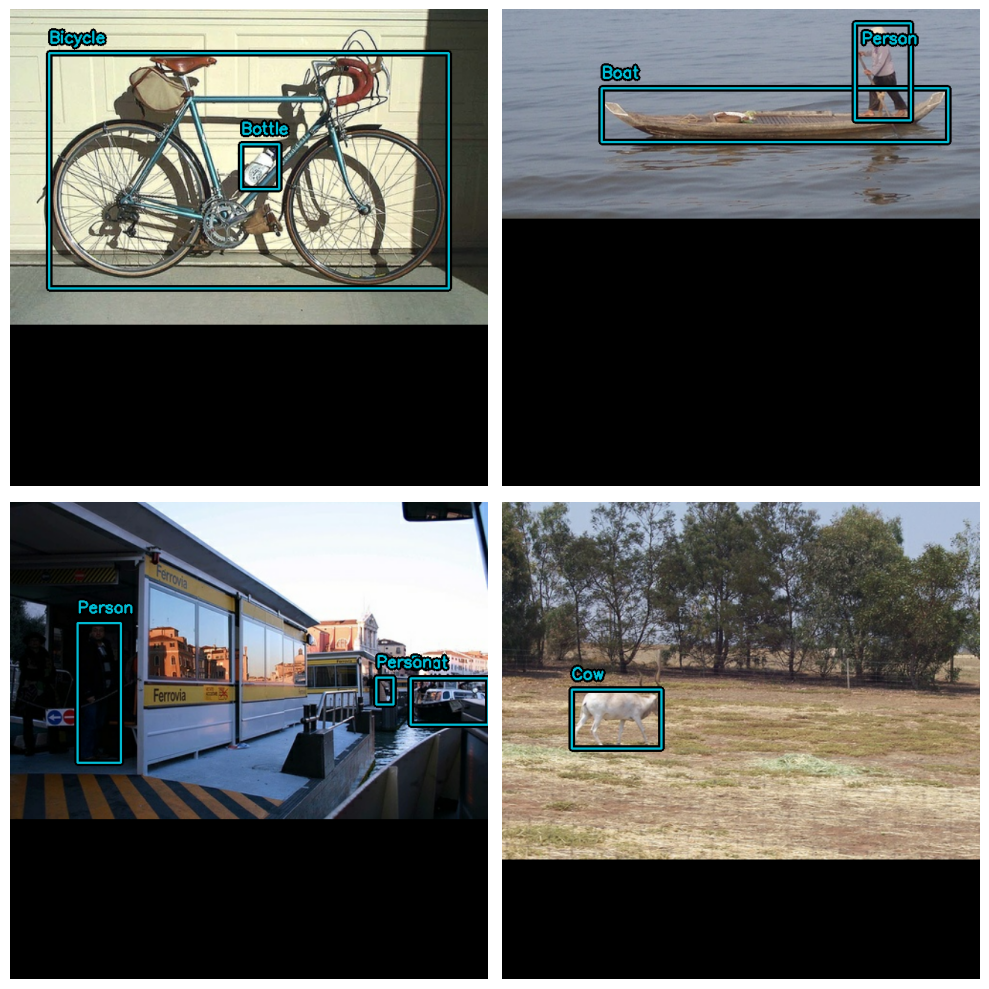

In [ ]:
visualize_dataset(
    eval_ds, bounding_box_format="xywh", value_range=(0, 255), rows=2, cols=2
)

Finally, let's unpackage our inputs from the preprocessing dictionary, and
prepare to feed the inputs into our model.  In order to be TPU compatible,
bounding box Tensors need to be `Dense` instead of `Ragged`.  If training on
GPU, you can omit the `bounding_box.to_dense()` call.  If omitted,
the KerasCV RetinaNet
label encoder will automatically correctly encode Ragged training targets.

In [ ]:

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

### Optimizer

In this guide, we use a standard SGD optimizer and rely on the
[`keras.callbacks.ReduceLROnPlateau`](https://keras.io/api/callbacks/reduce_lr_on_plateau/)
callback to reduce the learning rate.

You will always want to include a `global_clipnorm` when training object
detection models.  This is to remedy exploding gradient problems that frequently
occur when training object detection models.

In [ ]:
base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

To achieve the best results on your dataset, you'll likely want to hand craft a
`PiecewiseConstantDecay` learning rate schedule.
While `PiecewiseConstantDecay` schedules tend to perform better, they don't
translate between problems.

### Loss functions

You may not be familiar with the `"focal"` or `"smoothl1"` losses.  While not
common in other models, these losses are more or less staples in the object
detection world.

In short, ["Focal Loss"](https://arxiv.org/abs/1708.02002) places extra emphasis
on difficult training examples.  This is useful when training the classification
loss, as the majority of the losses are assigned to the background class.

"SmoothL1 Loss" is used to [prevent exploding gradients](https://arxiv.org/abs/1504.08083)
that often occur when attempting to perform the box regression task.

In KerasCV you can use these losses simply by passing the strings `"focal"` and
`"smoothl1"` to `compile()`:

### Metric evaluation

Just like any other metric, you can pass the `KerasCV` object detection metrics
to `compile()`.  The most popular object detection metrics are COCO metrics,
which were published alongside the MSCOCO dataset. KerasCV provides an
easy-to-use suite of COCO metrics under the `keras_cv.metrics.BoxCOCOMetrics`
symbol:

In [ ]:
coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format="xywh", evaluate_freq=20
)

Let's define a quick helper to print our metrics in a nice table:

In [ ]:

def print_metrics(metrics):
    maxlen = max([len(key) for key in result.keys()])
    print("Metrics:")
    print("-" * (maxlen + 1))
    for k, v in metrics.items():
        print(f"{k.ljust(maxlen+1)}: {v.numpy():0.2f}")


Due to the high computational cost of computing COCO metrics, the KerasCV
`BoxCOCOMetrics` component requires an `evaluate_freq` parameter to be passed to
its constructor.  Every `evaluate_freq`-th call to `update_state()`, the metric
will recompute the result.  In between invocations, a cached version of the
result will be returned.

To force an evaluation, you may call `coco_metrics.result(force=True)`:

In [ ]:

class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xywh",
            # passing 1e9 ensures we never evaluate until
            # `metrics.result(force=True)` is
            # called.
            evaluate_freq=1e9,
        )

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in tqdm.tqdm(self.data):
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)
        return logs


Our data pipeline is now complete!
We can now move on to model creation and training.

## Model creation

Next, let's use the KerasCV API to construct an untrained RetinaNet model.
In this tutorial we use a pretrained ResNet50 backbone from the imagenet
dataset.

KerasCV makes it easy to construct a `RetinaNet` with any of the KerasCV
backbones.  Simply use one of the presets for the architecture you'd like!

For example:

In [ ]:
model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(class_mapping),
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
)

94657128/94657128 [==============================] - 1s 0us/step


That is all it takes to construct a KerasCV RetinaNet.  The RetinaNet accepts
tuples of dense image Tensors and bounding box dictionaries to `fit()` and
`train_on_batch()`

This matches what we have constructed in our input pipeline above.

## Training our model

All that is left to do is train our model.  KerasCV object detection models
follow the standard Keras workflow, leveraging `compile()` and `fit()`.

Let's compile our model:

In [ ]:
model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
    # We will use our custom callback to evaluate COCO metrics
    metrics=None,
)

If you want to fully train the model, remove `.take(20)` from each
of the following dataset references.

In [ ]:
model.fit(
    train_ds.take(20),
    validation_data=eval_ds.take(20),
    # Run for 10-35~ epochs to achieve good scores.
    epochs=1,
    callbacks=[EvaluateCOCOMetricsCallback(eval_ds.take(20))],
)

20/20 [==============================] - ETA: 0s - loss: 1.8097 - box_loss: 0.6957 - classification_loss: 1.1140 - percent_boxes_matched_with_anchor: 0.9250 

100%|██████████| 20/20 [33:18<00:00, 99.94s/it]

20/20 [==============================] - 3071s 158s/step - loss: 1.8097 - box_loss: 0.6957 - classification_loss: 1.1140 - percent_boxes_matched_with_anchor: 0.9250 - val_loss: 2.0728 - val_box_loss: 0.6872 - val_classification_loss: 1.3856 - val_percent_boxes_matched_with_anchor: 0.9172 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00


## Inference and plotting results

KerasCV makes object detection inference simple.  `model.predict(images)`
returns a RaggedTensor of bounding boxes.  By default, `RetinaNet.predict()`
will perform a non max suppression operation for you.

In this section, we will use a `keras_cv` provided preset:

In [ ]:
model = keras_cv.models.RetinaNet.from_preset(
    "retinanet_resnet50_pascalvoc", bounding_box_format="xywh"
)

142662880/142662880 [==============================] - 1s 0us/step


Next, for convenience we construct a dataset with larger batches:

In [ ]:
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
visualization_ds = visualization_ds.shuffle(8)

Let's create a simple function to plot our inferences:

In [ ]:
#Print prediction format.
image, y_true = next(iter(visualization_ds.take(1)))

test_predict = model.predict(image)

print(test_predict)
print(type(test_predict))

1/1 [==============================] - 476s 476s/step
{'boxes': array([[[228.16151   , 254.60083   , 263.88275   , 208.57184   ],
        [  5.4833984 , 281.26248   , 372.96933   , 165.53058   ],
        [465.25256   , 165.68227   , 180.59814   , 318.77466   ],
        ...,
        [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
        [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
        [ -1.        ,  -1.        ,  -1.        ,  -1.        ]],

       [[ -1.        ,  -1.        ,  -1.        ,  -1.        ],
        [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
        [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
        ...,
        [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
        [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
        [ -1.        ,  -1.        ,  -1.        ,  -1.        ]],

       [[409.5794    ,  62.81197   ,  81.14929   , 126.862885  ],
        [290.67767   , 239.20857   , 124.187805 

In [ ]:

def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=4,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


You'll likely need to configure your NonMaxSuppression operation to achieve
visually appealing results:

In [ ]:
def visualize_detections2(model, dataset,predictions,  bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=4,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

  visualize_detections2(model, dataset = visualization_ds, bounding_box_format="xywh")

In [ ]:
model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

visualize_detections(model, dataset=visualization_ds, bounding_box_format="xywh")

Awesome!
One final helpful pattern to be aware of is to visualize
detections in a `keras.callbacks.Callback` to monitor training :

In [ ]:

class VisualizeDetections(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        visualize_detections(
            self.model, bounding_box_format="xywh", dataset=visualization_dataset
        )


#Saving the model and loading



In [ ]:
#model.save('test-saved.keras')

load_model = keras.models.load_model('test-saved.keras')
                                     #custom_objects = {'RetinaNet':keras_cv.models.RetinaNet, 'keras_cv.models>ResNetBackbone':keras_cv.models.ResNetBackbone})


filepath = tf.keras.utils.get_file(origin="https://i.imgur.com/gCNcJJI.jpg")
image = keras.utils.load_img(filepath)
image = np.array(image)

visualization.plot_image_gallery(
    np.array([image]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)
image_batch = inference_resizing([image])

y_pred = load_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)

#Saving weigths

In [ ]:
model.save_weights('./weights_model')

model_load_weights = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(class_mapping),
    # For more info on supported bounding box formats, visit
    # https://keras.io/api/keras_cv/bounding_box/
    bounding_box_format="xywh",
)

#Testing to compile before loading
# model_load_weights.compile(
#     classification_loss="focal",
#     box_loss="smoothl1",
#     optimizer=optimizer,
#     # We will use our custom callback to evaluate COCO metrics
#     metrics=None,
# )

model_load_weights.load_weights("./weights_model", skip_mismatch=False, by_name=False, options=None)

y_pred2 = load_model.predict(image_batch)
# y_pred is a bounding box Tensor:
# {"classes": ..., boxes": ...}
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred2,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)